In [18]:
import os
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import scipy.stats as scistats
import statistics as stats

from pathlib import Path


## Libraries, Helper Functions and High Level Variables

In [2]:
dir_path = Path(os.getcwd())
data_dir = str(os.path.join(dir_path,'data'))
balance_files = glob.glob(data_dir + "/poker_balances*.csv")
hands_files = glob.glob(data_dir + "/poker_hands*.csv")
table_files = glob.glob(data_dir + "/poker_table_info*.csv")

def get_hands_df():
    hands_dfs=[]

    for file in hands_files:
        new_df = pd.read_csv(file)
        hands_dfs.append(new_df)

    hands = pd.concat(hands_dfs)
    return hands
    
def get_games_df():
    balance_dfs=[]
    
    for file in balance_files:
        new_df = pd.read_csv(file)
        balance_dfs.append(new_df)
        
    balances = pd.concat(balance_dfs)
    return balances

def get_table_df():
    table_dfs=[]
    
    for file in table_files:
        new_df = pd.read_csv(file)
        table_dfs.append(new_df)
        
    tables = pd.concat(table_dfs)
    return tables


## Getting the Data and Augmentation

In [3]:
pd.set_option('display.max_columns', None)  
hands_base = get_hands_df()
games_base = get_games_df()
tables = get_table_df()

tables['category'] = np.where(tables['scenario_name'].str.startswith('smart'),'smart','conservative')

games = pd.merge(games_base,tables)
hands = pd.merge(hands_base,games)

## Data Samples

We have 3 individual tables: tables, games and hands.  They each represent different types of entities.  This will be explained per table.

### Table 

Our simulation software maps a scenario to a simulation, which in-turn runs a set of 2-6 players over 10 poker tables similar to simulation softwares concept of replications.  Each player within a scenario can have one of 3 personas: Smart Player, Conservative Player or Always Calls Player.  Smart Player runs a 100-card monte-carlo simulation everytime he has to make a betting decision, Conservative player ... and always calls player always calls no matter what happens.  Other types of player personas are implemented, but not used in this analysis.  We decided for this analysis to compare the smart player against the conservative player by having each player play 5 different scenarios against 1,2,3,4 and 5 always call type players. Than compare results between the two of them.  The Tables Dataframe below represents scenario and table level information eg simulation and replication info.

Fields:

* table_id -> replication id representing a poker table
* scenario_name -> represents the name of a simulation
* player_types -> a pipe delimited list of all player personas or types
* category -> if the table is part of the smart or conservative player analysis


In [4]:
tables.head(5)

table_id                      scenario_name  \
0         1         smart vs 1 all call player   
0        10         smart vs 1 all call player   
0       100  conservative vs 5 all call player   
0        11         smart vs 2 all call player   
0        12         smart vs 2 all call player   

                                        player_types      category  
0                       AlwaysCallPlayer|SmartPlayer         smart  
0                       AlwaysCallPlayer|SmartPlayer         smart  
0  AlwaysCallPlayer|AlwaysCallPlayer|AlwaysCallPl...  conservative  
0      AlwaysCallPlayer|AlwaysCallPlayer|SmartPlayer         smart  
0      AlwaysCallPlayer|AlwaysCallPlayer|SmartPlayer         smart

### Games

Each table is assigned a French-style poker deck of 52 cards, which it uses to play 100 sequential games of poker with.  It reshuffles the deck after each game.  The balances of the player are carried over between games.  The Games table contains the results of the games and the changes of each players balance as the 100 games progress.  It also records the overall outcome of the player within the game: won/lost and what the final hand would have been (straight, 2-pair, 3-pair etc).  The following information is contained in the Games Data Frame.

Fields:
* table_id -> a relational link to tables data frame representing the table or replication the row is associated with
* game_id -> an id representing one of 100 sequential games for a given table ordered chronologically.
* player_name -> name of the player usually player 1,2,3,4,5,6
* player_type -> the player personal or strategy used during the match
* game_result -> if the player won or lost the round
* game_reason -> did the player win or lose the match during the final hand or did he fold or alternatively was the only person that didn't fodl.
* blind type -> was the player the small or large blind
* beginning balance -> the players balance before joining the table.
* game_start_balance -> the player balance during the start of the poker game
* game_end_balance -> the player balance after the end of the poker game
* game_net_change -> the net change in players balance after the conclusion of the game
* scenario_name -> what scenario it belongs too
* player_types -> what player personas were involved in the game
* category -> what category smart or conservative player analysis dis this game belong to.


In [6]:
games.head(5)

table_id  game_id player_name  player_type game_result game_reason  \
0         1        1   players_1  SmartPlayer        lost   lost_game   
1         1        2   players_1  SmartPlayer         won    won_game   
2         1        3   players_1  SmartPlayer         won    won_game   
3         1        4   players_1  SmartPlayer        lost        fold   
4         1        5   players_1  SmartPlayer         won    won_game   

  blind_type  final_hand  beginning_balance  game_start_balance  \
0      small    one_pair             100000            100000.0   
1        big    one_pair             100000             99990.0   
2      small    straight             100000            100000.0   
3        big    straight             100000            100210.0   
4      small  full_house             100000            100200.0   

   game_end_balance  game_net_change               scenario_name  \
0           99990.0            -10.0  smart vs 1 all call player   
1          100000.0             10.0  smart vs 1 all call player   
2          100210.0            210.0  smart vs 1 all call player   
3          100200.0            -10.0  smart vs 1 all call player   
4          100310.0            110.0  smart vs 1 all call player   

                   player_types category  
0  AlwaysCallPlayer|SmartPlayer    smart  
1  AlwaysCallPlayer|SmartPlayer    smart  
2  AlwaysCallPlayer|SmartPlayer    smart  
3  AlwaysCallPlayer|SmartPlayer    smart  
4  AlwaysCallPlayer|SmartPlayer    smart

### Hands

Each Game of poker is actually a set of up to 12 betting decisions per player.  3 for pre-flob, 3-card community, 4-card community and 5 card community post-flops.  A player can: call/check, raise or fold the hand.  Each row in the hands dataframe represents one of these betting decisions and provides all the information a player had when making the bet.  It also shows you the result of the bet.  Useful for stepping through the players action during a game.

Fields:
* table_id -> table associated with the bet
* game_id -> game associated with the bet
* player_name -> player name associated with the bet
* player_type -> player persona or strategy used during the bet
* bet_number -> for this specific game_id what bet number this is (1st bet, 2nd bet etc)
* opponents -> number of opponents left
* call -> how much the player needs to call to stay in the game
* current -> how much the player has in the pot right now
* pot -> how large the pot or reward is
* allowed -> if the player was allowed to raise or if it was the last round of bets
* hand1 -> first card in the players hand (of 2)
* hand2 -> the second card in the players hand (of 2)
* community1-5 -> 1-5 community card in the post flop

Everything after these fields are created from a joing to both table and game for convenice.

In [7]:
hands.head(5)

table_id  game_id player_name  player_type  bet_number  opponents  call  \
0         1        1   players_1  SmartPlayer           1          1     5   
1         1        1   players_1  SmartPlayer           2          1     0   
2         1        1   players_1  SmartPlayer           3          1     0   
3         1        1   players_1  SmartPlayer           4          1     0   
4         1        2   players_1  SmartPlayer           1          1     0   

   current  final  pot  allowed       hand1       hand2 community1 community2  \
0        5   10.0   15     True  4-diamonds  Q-diamonds      Z-N/A      Z-N/A   
1       10   10.0   20     True  4-diamonds  Q-diamonds    5-clubs   6-hearts   
2       10   10.0   20     True  4-diamonds  Q-diamonds    5-clubs   6-hearts   
3       10   10.0   20     True  4-diamonds  Q-diamonds    5-clubs   6-hearts   
4       10   10.0   20     True    J-spades    Q-hearts      Z-N/A      Z-N/A   

  community3 community4 community5 game_result game_reason blind_type  \
0      Z-N/A      Z-N/A      Z-N/A        lost   lost_game      small   
1   8-spades      Z-N/A      Z-N/A        lost   lost_game      small   
2   8-spades   K-spades      Z-N/A        lost   lost_game      small   
3   8-spades   K-hearts   K-spades        lost   lost_game      small   
4      Z-N/A      Z-N/A      Z-N/A         won    won_game        big   

  final_hand  beginning_balance  game_start_balance  game_end_balance  \
0   one_pair             100000            100000.0           99990.0   
1   one_pair             100000            100000.0           99990.0   
2   one_pair             100000            100000.0           99990.0   
3   one_pair             100000            100000.0           99990.0   
4   one_pair             100000             99990.0          100000.0   

   game_net_change               scenario_name                  player_types  \
0            -10.0  smart vs 1 all call player  AlwaysCallPlayer|SmartPlayer   
1            -10.0  smart vs 1 all call player  AlwaysCallPlayer|SmartPlayer   
2            -10.0  smart vs 1 all call player  AlwaysCallPlayer|SmartPlayer   
3            -10.0  smart vs 1 all call player  AlwaysCallPlayer|SmartPlayer   
4             10.0  smart vs 1 all call player  AlwaysCallPlayer|SmartPlayer   

  category  
0    smart  
1    smart  
2    smart  
3    smart  
4    smart

# High Level Statistics - All Simulations

We provide a high-level aggregation across all simulations to provide context into the simulation software as a whole.  Since the simulation software is highly configurable, these high level statistics are useful for gauging things like performance or to catch anomalies.

In [8]:
player_final_hands = hands.query('community5 != "Z-N/A"').groupby(['table_id','game_id','player_name','hand1','hand2','community1','community2','community3','community4','community5','final_hand']).count().game_result.reset_index().groupby('final_hand').game_id.count().reset_index()
player_final_hands_type, player_final_hands_type_numbers = list(zip(*player_final_hands.values))
player_final_hands_type = ['player final _hand' + card for card in player_final_hands_type]

winning_hands = games.query('game_result == "won"').groupby(['game_id','final_hand']).count().groupby('final_hand').count().reset_index()[['final_hand','table_id']]
winning_hand_type, winning_hand_type_numbers = list(zip(*winning_hands.values))
winning_hand_type = ['won by ' + card for card in winning_hand_type]

simulation_overview = pd.DataFrame(
    data={
            "Metric":[
                "scenarios",
                "player strategies",
                "active players",
                "player - bet decisions",
                "tables",
                "games", 
                "average chip gain/loss",
                "average pot size",
                "unique 2-card combos",
                "unique end combos",
                "unique 3-card flops",
                "unique 4-card flops",
                "unique 5-card flops"
            ] + list(player_final_hands_type) +
                list(winning_hand_type),
            "Total":[
                tables.scenario_name.nunique(),
                games.player_type.nunique(),
                games.groupby(['table_id','player_name']).game_result.count().reset_index().shape[0],
                hands.shape[0],
                tables.table_id.nunique(),
                games.game_id.nunique(),
                round(games.game_net_change.mean(),0),
                round(hands.pot.mean(),0),
                hands.groupby(['hand1','hand2']).count().reset_index().shape[0],
                hands.query('community5 != "Z-N/A"').groupby(['hand1','hand2','community1','community2','community3','community4','community5']).count().reset_index().shape[0],
                hands.query('community1 != "Z-N/A"').groupby(['community1','community2','community3']).count().reset_index().shape[0],
                hands.query('community4 != "Z-N/A"').groupby(['community1','community2','community3','community4']).count().reset_index().shape[0],
                hands.query('community5 != "Z-N/A"').groupby(['community1','community2','community3','community4','community5']).count().reset_index().shape[0]
            ] + list(player_final_hands_type_numbers) +
                list(winning_hand_type_numbers)
    },
    columns = ['Metric','Total']
)

simulation_overview

Metric     Total
0                          scenarios      10.0
1                  player strategies       3.0
2                     active players     400.0
3             player - bet decisions  177818.0
4                             tables     100.0
5                              games   10000.0
6             average chip gain/loss       0.0
7                   average pot size     324.0
8               unique 2-card combos    1326.0
9                  unique end combos   36823.0
10               unique 3-card flops   13119.0
11               unique 4-card flops   16899.0
12               unique 5-card flops    9655.0
13           player final _handflush    1174.0
14    player final _handfour_of_kind      76.0
15      player final _handfull_house    1068.0
16       player final _handhigh_card    6155.0
17        player final _handone_pair   15896.0
18        player final _handstraight    1682.0
19  player final _handstraight_flush      15.0
20   player final _handthree_of_kind    1837.0
21        player final _handtwo_pair    8905.0
22                      won by flush     781.0
23               won by four_of_kind      62.0
24                 won by full_house     825.0
25                  won by high_card     206.0
26                   won by one_pair    2747.0
27                   won by straight    1158.0
28             won by straight_flush      14.0
29              won by three_of_kind    1024.0
30                   won by two_pair    3183.0

# Performance over all Games by Player Type

Below we provide a reference for all replications (tables) within each scenario by averaging the mean net change in each persons chips over all games as well as variance and standard deviation.  We also report the players, lowest and highest balances.

In [66]:
pd.set_option('display.max_rows', 500)

table_level_statistics = games.groupby(['category','scenario_name','table_id','player_name','player_type']).agg({
    "game_net_change":[np.mean,lambda col: np.var(col,ddof=1),'count'],
    "game_end_balance":[np.min,np.max]
}).reset_index().sort_values(['table_id','player_name'])

table_level_statistics.columns = ['category','scenario_name','table_id','player_name','player_type','table_mean','table_variance','count','player_lowest_balance','player_highest_balance']
table_level_statistics['confidence_interval'] = table_level_statistics.apply(lambda df: scistats.t.interval(alpha=.99,df=df['count'],loc=df['table_mean'],scale=np.sqrt(df['table_variance'])/np.sqrt(df['count'])),axis=1)
table_level_statistics['lower_bound_95%'], table_level_statistics['upper_bound_95%'] = zip(*table_level_statistics.confidence_interval)
table_level_statistics.pop('confidence_interval')
table_level_statistics



category                      scenario_name  table_id player_name  \
200         smart         smart vs 1 all call player         1   players_1   
201         smart         smart vs 1 all call player         1   players_2   
202         smart         smart vs 1 all call player         2   players_1   
203         smart         smart vs 1 all call player         2   players_2   
204         smart         smart vs 1 all call player         3   players_1   
205         smart         smart vs 1 all call player         3   players_2   
206         smart         smart vs 1 all call player         4   players_1   
207         smart         smart vs 1 all call player         4   players_2   
208         smart         smart vs 1 all call player         5   players_1   
209         smart         smart vs 1 all call player         5   players_2   
210         smart         smart vs 1 all call player         6   players_1   
211         smart         smart vs 1 all call player         6   players_2   
212         smart         smart vs 1 all call player         7   players_1   
213         smart         smart vs 1 all call player         7   players_2   
214         smart         smart vs 1 all call player         8   players_1   
215         smart         smart vs 1 all call player         8   players_2   
216         smart         smart vs 1 all call player         9   players_1   
217         smart         smart vs 1 all call player         9   players_2   
218         smart         smart vs 1 all call player        10   players_1   
219         smart         smart vs 1 all call player        10   players_2   
220         smart         smart vs 2 all call player        11   players_1   
221         smart         smart vs 2 all call player        11   players_2   
222         smart         smart vs 2 all call player        11   players_3   
223         smart         smart vs 2 all call player        12   players_1   
224         smart         smart vs 2 all call player        12   players_2   
225         smart         smart vs 2 all call player        12   players_3   
226         smart         smart vs 2 all call player        13   players_1   
227         smart         smart vs 2 all call player        13   players_2   
228         smart         smart vs 2 all call player        13   players_3   
229         smart         smart vs 2 all call player        14   players_1   
230         smart         smart vs 2 all call player        14   players_2   
231         smart         smart vs 2 all call player        14   players_3   
232         smart         smart vs 2 all call player        15   players_1   
233         smart         smart vs 2 all call player        15   players_2   
234         smart         smart vs 2 all call player        15   players_3   
235         smart         smart vs 2 all call player        16   players_1   
236         smart         smart vs 2 all call player        16   players_2   
237         smart         smart vs 2 all call player        16   players_3   
238         smart         smart vs 2 all call player        17   players_1   
239         smart         smart vs 2 all call player        17   players_2   
240         smart         smart vs 2 all call player        17   players_3   
241         smart         smart vs 2 all call player        18   players_1   
242         smart         smart vs 2 all call player        18   players_2   
243         smart         smart vs 2 all call player        18   players_3   
244         smart         smart vs 2 all call player        19   players_1   
245         smart         smart vs 2 all call player        19   players_2   
246         smart         smart vs 2 all call player        19   players_3   
247         smart         smart vs 2 all call player        20   players_1   
248         smart         smart vs 2 all call player        20   players_2   
249         smart         smart vs 2 all call player        20   players_3   
250         smart         smart

Below graph, we look at all 10 of our scenarios by player.  The top 10 graphs represent our conservative scenarios in descending order of number of players.  The bottom 10 scenarios show Smart Player in descending number of opponents.  You can see that Smart Player shifts right as more players are added, while his opponents tend to lose about the same amount of chips per table.  This is due to the fact that the always call opponents make the same type of decisions and lose about the same percent of the time, but the smart player gets to reap the benefits of those calls by on average winning a larger parts due to more contributors.

Text(0.5, 0.98, 'Conservative vs Smart Player - 2 to 6 player games')

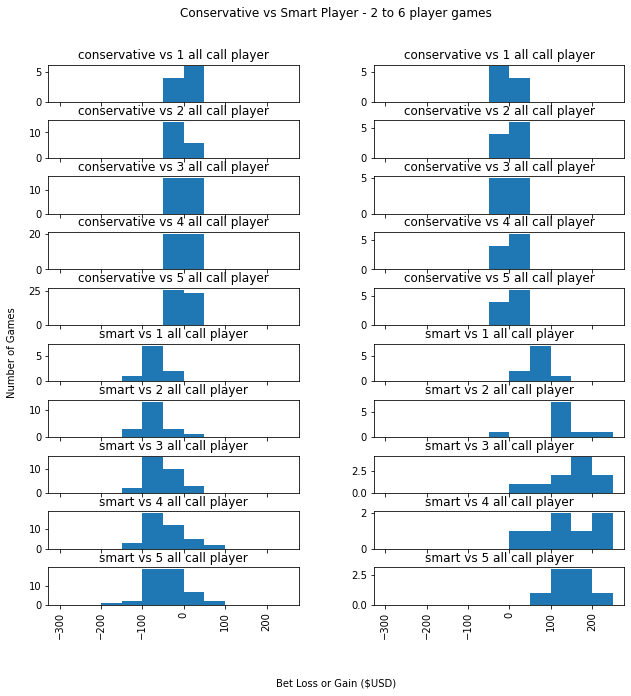

In [126]:
fig, axis = plt.subplots(10,2,figsize=(10, 10), sharex = True)

table_level_statistics.hist(
        column='table_mean',
        by=['scenario_name','player_type'],
        grid = True,
        bins = list(range(-300,300,50)),
        ax = axis
)

for row in axis:
    for col in row:
        col.set_title(col.title.get_text().split(',')[0][1:])

fig.text(0.5,0.04, "Bet Loss or Gain ($USD)", ha="center", va="center")
fig.text(0.05,0.5, "Number of Games", ha="center", va="center", rotation=90)

plt.suptitle("Conservative vs Smart Player - 2 to 6 player games")



We can also look at the mean, variance and standard deviation of players across all games within a scenario.  Sometimes interesting patterns emerge.

In [29]:
game_level_statistics = games.groupby(['category','scenario_name','player_name','player_type']).agg({
    "game_net_change":[np.mean,lambda col: np.var(col,ddof=1)],
    "game_end_balance":[np.min,np.max]
}).reset_index().sort_values(['player_name'])

game_level_statistics.columns = ['category','scenario_name','player_name','player_type','game_mean','game_variance','min_balance','max_balance']

game_level_statistics.sort_values(['scenario_name','player_name'])

category                      scenario_name player_name  \
0   conservative  conservative vs 1 all call player   players_1   
1   conservative  conservative vs 1 all call player   players_2   
2   conservative  conservative vs 2 all call player   players_1   
3   conservative  conservative vs 2 all call player   players_2   
4   conservative  conservative vs 2 all call player   players_3   
5   conservative  conservative vs 3 all call player   players_1   
6   conservative  conservative vs 3 all call player   players_2   
7   conservative  conservative vs 3 all call player   players_3   
8   conservative  conservative vs 3 all call player   players_4   
9   conservative  conservative vs 4 all call player   players_1   
10  conservative  conservative vs 4 all call player   players_2   
11  conservative  conservative vs 4 all call player   players_3   
12  conservative  conservative vs 4 all call player   players_4   
13  conservative  conservative vs 4 all call player   players_5   
14  conservative  conservative vs 5 all call player   players_1   
15  conservative  conservative vs 5 all call player   players_2   
16  conservative  conservative vs 5 all call player   players_3   
17  conservative  conservative vs 5 all call player   players_4   
18  conservative  conservative vs 5 all call player   players_5   
19  conservative  conservative vs 5 all call player   players_6   
20         smart         smart vs 1 all call player   players_1   
21         smart         smart vs 1 all call player   players_2   
22         smart         smart vs 2 all call player   players_1   
23         smart         smart vs 2 all call player   players_2   
24         smart         smart vs 2 all call player   players_3   
25         smart         smart vs 3 all call player   players_1   
26         smart         smart vs 3 all call player   players_2   
27         smart         smart vs 3 all call player   players_3   
28         smart         smart vs 3 all call player   players_4   
29         smart         smart vs 4 all call player   players_1   
30         smart         smart vs 4 all call player   players_2   
31         smart         smart vs 4 all call player   players_3   
32         smart         smart vs 4 all call player   players_4   
33         smart         smart vs 4 all call player   players_5   
34         smart         smart vs 5 all call player   players_1   
35         smart         smart vs 5 all call player   players_2   
36         smart         smart vs 5 all call player   players_3   
37         smart         smart vs 5 all call player   players_4   
38         smart         smart vs 5 all call player   players_5   
39         smart         smart vs 5 all call player   players_6   

           player_type   game_mean  game_variance   min_balance    max_balance  
0   ConservativePlayer   -0.310000      94.698599  99790.000000  100230.000000  
1     AlwaysCallPlayer    0.310000      94.698599  99770.000000  100210.000000  
2   ConservativePlayer    0.375000     195.730105  99850.000000  100240.000000  
3     AlwaysCallPlayer   -0.255000     189.499474  99815.000000  100160.000000  
4     AlwaysCallPlayer   -0.120000     191.577177  99715.000000  100185.000000  
5   ConservativePlayer    0.286667     290.764142  99813.333333  100293.333333  
6     AlwaysCallPlayer   -0.373333     279.495673  99710.000000  100333.333333  
7     AlwaysCallPlayer    0.660000     297.528595  99820.000000  100490.000000  
8     AlwaysCallPlayer   -0.573333     276.102947  99590.000000  100300.000000  
9   ConservativePlayer    0.310000     388.859426  99696.666667  100280.000000  
10    AlwaysCallPlayer   -0.823333     344.928161  99635.000000  100220.000000  
11    AlwaysCallPlayer    0.893333     403.727906  99690.000000  100376.666667  
12    AlwaysCallPlayer   -0.540000     361.052786  99655.000000  100300.000000  
13    AlwaysCallPlayer    0.160000     376.500901  99786.666667  100381.666667  
14  ConservativePlayer   -0.215000     459.03

After taking out bets between -25 and 25, we look at the distribution of tails to see if anything interesting occurs.  We can note that for Smart Player, he tends to lose about as often as the Always Call Player.  That said, when Smart Player wins he tends to win by a lot.  This I think is due to the fact that he raises $100 when he thinks he has a 75 percent chance of winning.  He might do this muliple times in a round if he is certain of a win.

Text(0.5, 0.98, 'Conservative vs Smart Player - 2 to 6 player games')

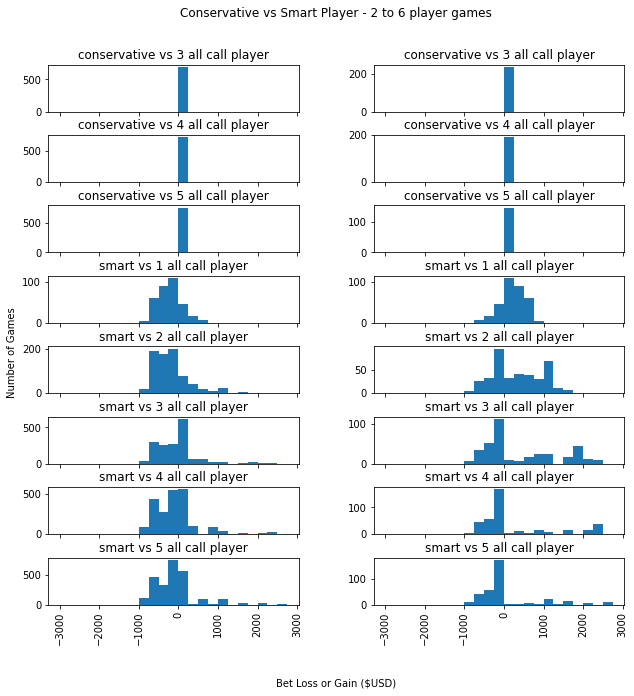

In [133]:
fig, axis = plt.subplots(8,2,figsize=(10, 10), sharex = True)

games.query('game_net_change < -25 or game_net_change > 25').hist(
        column='game_net_change',
        by=['scenario_name','player_type'],
        grid = True,
        bins = list(range(-3000,3000,250)),
        ax = axis
)

for row in axis:
    for col in row:
        col.set_title(col.title.get_text().split(',')[0][1:])

fig.text(0.5,0.04, "Bet Loss or Gain ($USD)", ha="center", va="center")
fig.text(0.05,0.5, "Number of Games", ha="center", va="center", rotation=90)

plt.suptitle("Conservative vs Smart Player - 2 to 6 player games")

The overall game end balance is sequential, so it's a bit misleading to graph it as a box plot since each observation is not independent.  That said, the patterns in the distributions of end balances do have interesting properties in terms of ranges, mean and quartile that create an interesting observation.  Smart player's average is higher than 75% quantile of the All Call Players with the bottom of his range being about as bad as the mean of the all call players.  Smart playres end balance has significant amount of outliers sometimes 30% or more from the starting balanace.  The end balance for all call player tends to be lower, but not so drastic as the smart player.  partially due to the fact that in multiplayer games, Smart player can collect from many Always call players mitigating the damage.

[Text(1, 0, 'always call player - conservative scenario'),
 Text(2, 0, 'always call player - smart scenario'),
 Text(3, 0, 'conservative player - conservative scenario'),
 Text(4, 0, 'smart player - smart scenario')]

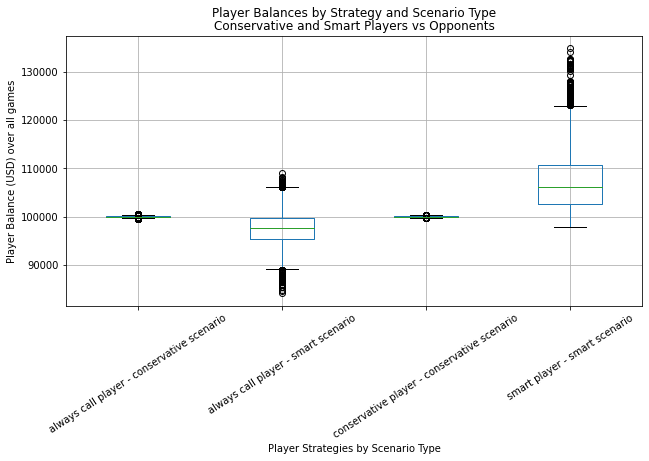

In [212]:
axis = games.boxplot(
        column=['game_end_balance'],
        by=['player_type','category'],
        figsize=(10,5),
        rot=33
)

plt.suptitle("Player Balances by Strategy and Scenario Type")
axis.set_title('Conservative and Smart Players vs Opponents')
axis.set_ylabel('Player Balance (USD) over all games')
axis.set_xlabel('Player Strategies by Scenario Type')

axis_replace={
    'AlwaysCallPlayer': 'always call player',
    'SmartPlayer': 'smart player',
    'ConservativePlayer': 'conservative player'
}

axis_cat_labels = [ax.get_text()[1:-1].split(',') for ax in axis.get_xmajorticklabels()]
axis_cat_labels = [axis_replace[ax[0]] + ' -' + ax[1] + ' scenario' for ax in axis_cat_labels]
axis.set_xticklabels(axis_cat_labels)


# Performance of Player Balances over Time

In [15]:
time_series = games[['scenario_name','player_name','player_type','table_id','game_id','game_end_balance']]
time_series['game_id'] = (time_series['game_id'] - 1) % 100
time_series['table_id'] = (time_series['table_id'] - 1) % 10
time_series = time_series.pivot_table(index=['scenario_name','player_name','player_type','table_id'],columns=['game_id'],values='game_end_balance').reset_index()
time_series

c:\users\silbe\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\silbe\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


game_id                      scenario_name player_name         player_type  \
0        conservative vs 1 all call player   players_1  ConservativePlayer   
1        conservative vs 1 all call player   players_1  ConservativePlayer   
2        conservative vs 1 all call player   players_1  ConservativePlayer   
3        conservative vs 1 all call player   players_1  ConservativePlayer   
4        conservative vs 1 all call player   players_1  ConservativePlayer   
5        conservative vs 1 all call player   players_1  ConservativePlayer   
6        conservative vs 1 all call player   players_1  ConservativePlayer   
7        conservative vs 1 all call player   players_1  ConservativePlayer   
8        conservative vs 1 all call player   players_1  ConservativePlayer   
9        conservative vs 1 all call player   players_1  ConservativePlayer   
10       conservative vs 1 all call player   players_2    AlwaysCallPlayer   
11       conservative vs 1 all call player   players_2    AlwaysCallPlayer   
12       conservative vs 1 all call player   players_2    AlwaysCallPlayer   
13       conservative vs 1 all call player   players_2    AlwaysCallPlayer   
14       conservative vs 1 all call player   players_2    AlwaysCallPlayer   
15       conservative vs 1 all call player   players_2    AlwaysCallPlayer   
16       conservative vs 1 all call player   players_2    AlwaysCallPlayer   
17       conservative vs 1 all call player   players_2    AlwaysCallPlayer   
18       conservative vs 1 all call player   players_2    AlwaysCallPlayer   
19       conservative vs 1 all call player   players_2    AlwaysCallPlayer   
20       conservative vs 2 all call player   players_1  ConservativePlayer   
21       conservative vs 2 all call player   players_1  ConservativePlayer   
22       conservative vs 2 all call player   players_1  ConservativePlayer   
23       conservative vs 2 all call player   players_1  ConservativePlayer   
24       conservative vs 2 all call player   players_1  ConservativePlayer   
25       conservative vs 2 all call player   players_1  ConservativePlayer   
26       conservative vs 2 all call player   players_1  ConservativePlayer   
27       conservative vs 2 all call player   players_1  ConservativePlayer   
28       conservative vs 2 all call player   players_1  ConservativePlayer   
29       conservative vs 2 all call player   players_1  ConservativePlayer   
30       conservative vs 2 all call player   players_2    AlwaysCallPlayer   
31       conservative vs 2 all call player   players_2    AlwaysCallPlayer   
32       conservative vs 2 all call player   players_2    AlwaysCallPlayer   
33       conservative vs 2 all call player   players_2    AlwaysCallPlayer   
34       conservative vs 2 all call player   players_2    AlwaysCallPlayer   
35       conservative vs 2 all call player   players_2    AlwaysCallPlayer   
36       conservative vs 2 all call player   players_2    AlwaysCallPlayer   
37       conservative vs 2 all call player   players_2    AlwaysCallPlayer   
38       conservative vs 2 all call player   players_2    AlwaysCallPlayer   
39       conservative vs 2 all call player   players_2    AlwaysCallPlayer   
40       conservative vs 2 all call player   players_3    AlwaysCallPlayer   
41       conservative vs 2 all call player   players_3    AlwaysCallPlayer   
42       conservative vs 2 all call player   players_3    AlwaysCallPlayer   
43       conservative vs 2 all call player   players_3    AlwaysCallPlayer   
44       conservative vs 2 all call player   players_3    AlwaysCallPlayer   
45       conservative vs 2 all call player   players_3    AlwaysCallPlayer   
46       conservative vs 2 all call player   players_3    AlwaysCallPlayer   
47       conservative vs 2 all call player   players_3    AlwaysCallPlayer   
48       conservative vs 2 all call player   players_3    AlwaysCallPlayer   
49       conservative vs 2 all call player   players_3    AlwaysCallPlayer   
50       conservative 

TypeError: 'str' object is not callable

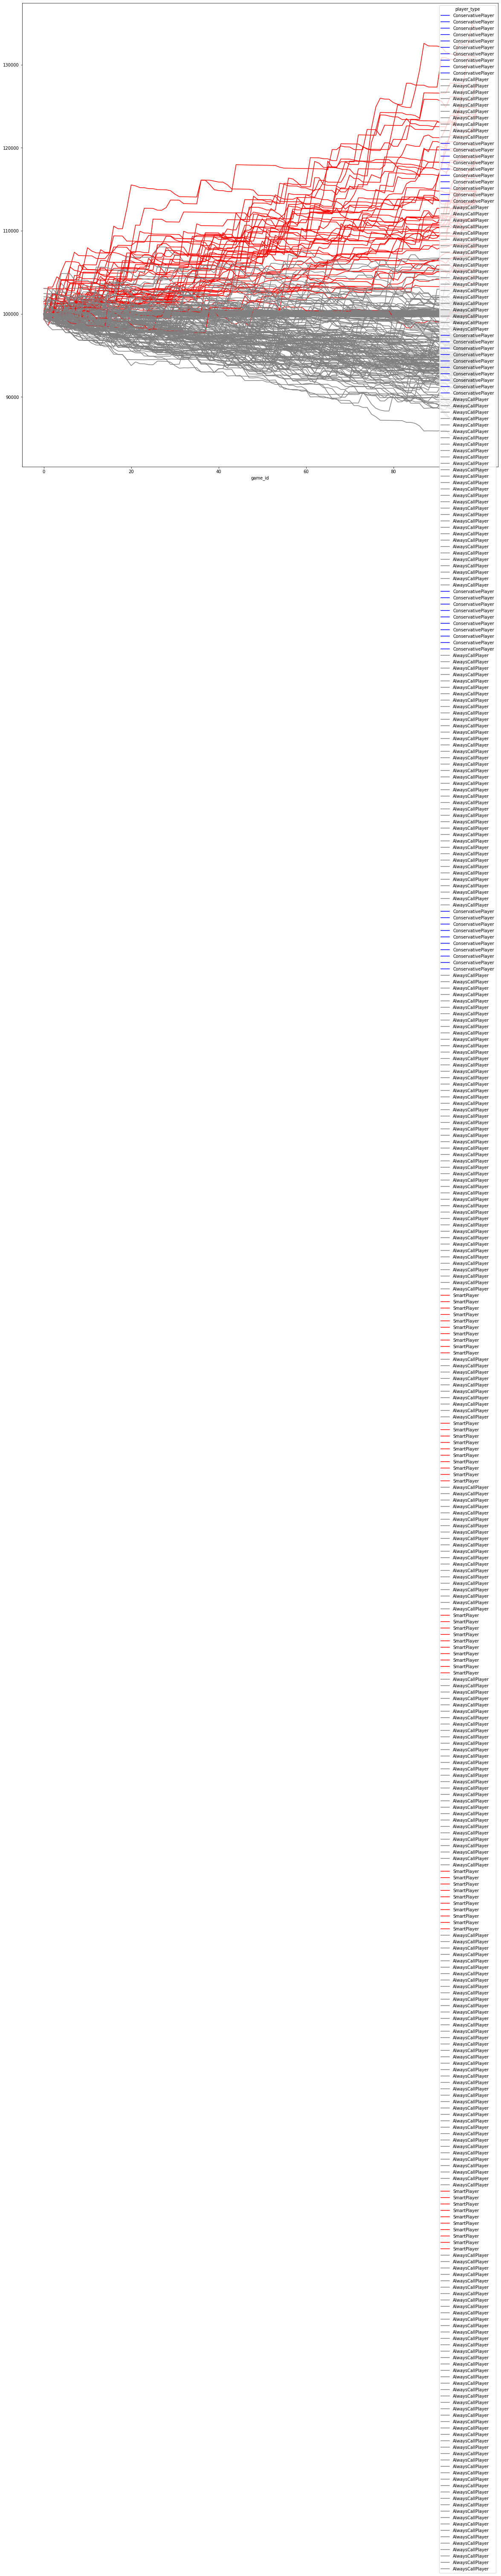

In [214]:
player_type = time_series[['player_type'] + [col for col in time_series.columns if isinstance(col,int)]]
colors = player_type['player_type'].apply(lambda x: 'red' if x == 'SmartPlayer' else 'blue' if x == 'ConservativePlayer' else 'grey')

f = plt.figure()
player_type.set_index('player_type').T.plot(color = colors,ax=f.gca(),figsize=(20, 20))
plt.title('Monte Carlo Players (red) vs Players That Always Call (Blue) Balance in USD (50 players)', color='black',size = 20)
plt.ylabel('Gambling Chips USD', size = 20)
plt.xlabel('sequential games of poker (100 per table)', size = 20)
plt.legend(['probabilistic player','always call player'],labelcolor=['r','b'], loc='center left', bbox_to_anchor=(1.0, 0.5),prop={'size': 20})


In [215]:
player_type.set_index('player_type').T

player_type  ConservativePlayer  ConservativePlayer  ConservativePlayer  \
game_id                                                                   
0                       99990.0            100010.0             99990.0   
1                      100000.0            100000.0            100000.0   
2                       99990.0             99990.0             99990.0   
3                       99980.0             99990.0            100000.0   
4                       99970.0             99980.0            100010.0   
5                       99980.0             99990.0            100000.0   
6                       99990.0             99980.0             99990.0   
7                      100000.0             99990.0            100000.0   
8                      100010.0             99980.0             99990.0   
9                      100020.0             99980.0             99980.0   
10                     100030.0             99990.0             99990.0   
11                     100040.0             99980.0            100000.0   
12                     100030.0             99970.0            100000.0   
13                     100020.0             99960.0            100010.0   
14                     100030.0             99950.0            100000.0   
15                     100040.0             99940.0             99990.0   
16                     100030.0             99930.0             99980.0   
17                     100020.0             99920.0             99990.0   
18                     100010.0             99920.0             99980.0   
19                     100020.0             99910.0             99970.0   
20                     100020.0             99920.0             99960.0   
21                     100010.0             99930.0             99970.0   
22                     100020.0             99940.0             99960.0   
23                     100010.0             99930.0             99950.0   
24                     100010.0             99940.0             99960.0   
25                     100000.0             99950.0             99950.0   
26                     100010.0             99960.0             99940.0   
27                     100000.0             99950.0             99930.0   
28                      99990.0             99940.0             99920.0   
29                      99980.0             99950.0             99920.0   
30                      99990.0             99960.0             99930.0   
31                     100000.0             99950.0             99930.0   
32                     100010.0             99940.0             99940.0   
33                     100000.0             99950.0             99930.0   
34                      99990.0             99960.0             99920.0   
35                      99980.0             99950.0             99930.0   
36                      99990.0             99960.0             99940.0   
37                      99980.0             99950.0             99950.0   
38                      99970.0             99940.0             99940.0   
39                      99980.0             99930.0             99950.0   
40                      99990.0             99940.0             99940.0   
41                      99980.0             99950.0             99940.0   
42                      99970.0             99960.0             99930.0   
43                      99980.0             99970.0             99920.0   
44                      99970.0             99980.0             99910.0   
45                      99980.0             99990.0             99900.0   
46                      99990.0             99980.0             99890.0   
47                     100000.0             99990.0             99900.0   
48                     100010.0             99980.0             99910.0   
49                     100020.0             99990.0             99900.0   
50                     100030.0             99980.0             99910.0   
51                     10

# Analysis of End Game Results

# Analysis of 2 Card Games, Flob and River performance